# Клиенты

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# === 1. Загрузка данных ===
file_path = "Обновленный_Отчет.xlsx"
df = pd.read_excel(file_path)

# Приведём названия колонок к удобному виду
df.columns = [c.strip().lower() for c in df.columns]

# Преобразуем дату
df['дата'] = pd.to_datetime(df['дата'])

C:\Users\Каролина\AppData\Local\Temp\ipykernel_8504\169176624.py:9: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['дата'] = pd.to_datetime(df['дата'])


In [3]:
# === 2. RFM-метрики ===
max_date = df['дата'].max()

rfm = df.groupby('компания').agg({
    'дата': lambda x: (max_date - x.max()).days,  # Recency
    'сумма (с ндс)': 'sum',  # Monetary
    'количество': 'count'  # Frequency (по заказам)
}).reset_index()

rfm.columns = ['компания', 'recency', 'monetary', 'frequency']

In [4]:
# === 3. Масштабирование признаков ===
X = rfm[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

c:\anaconda\envs\lab_01\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda\envs\lab_01\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda\envs\lab_01\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda\envs\lab_01\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows wi

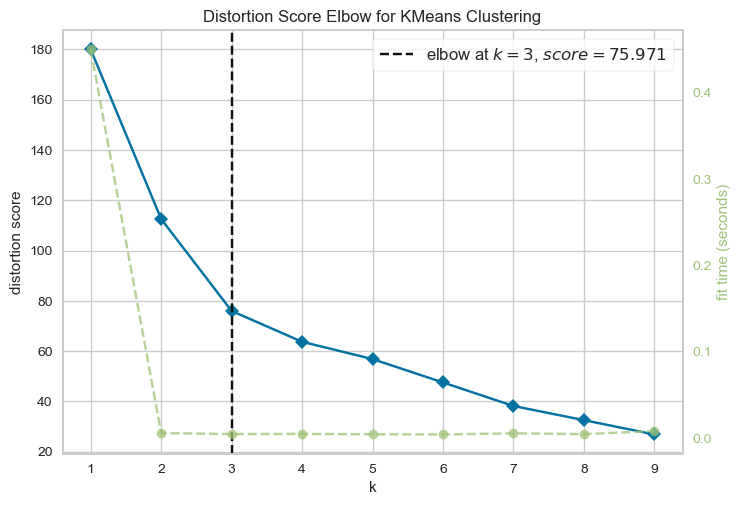

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model_KMeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(model_KMeans, k=(1,10))
visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [8]:
model_KMeans_3 = KMeans(random_state=42, n_clusters=3)
rfm['cluster'] = model_KMeans_3.fit_predict(X_scaled)

c:\anaconda\envs\lab_01\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [10]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(X_scaled, rfm['cluster'])
print("Silhouette Score:", silhouette)


Silhouette Score: 0.3822797210504518


In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

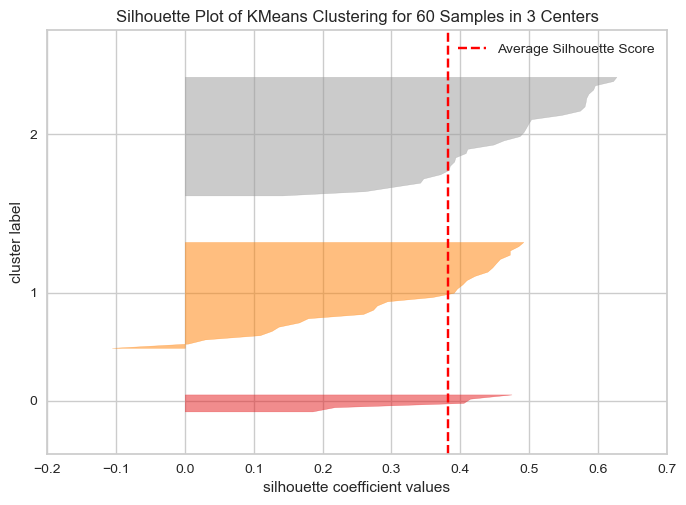

In [12]:
silhouette_3 = SilhouetteVisualizer(model_KMeans_3)

silhouette_3.fit(X_scaled)        # Fit the data to the visualizer
silhouette_3.show();        # Finalize and render the figure

c:\anaconda\envs\lab_01\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


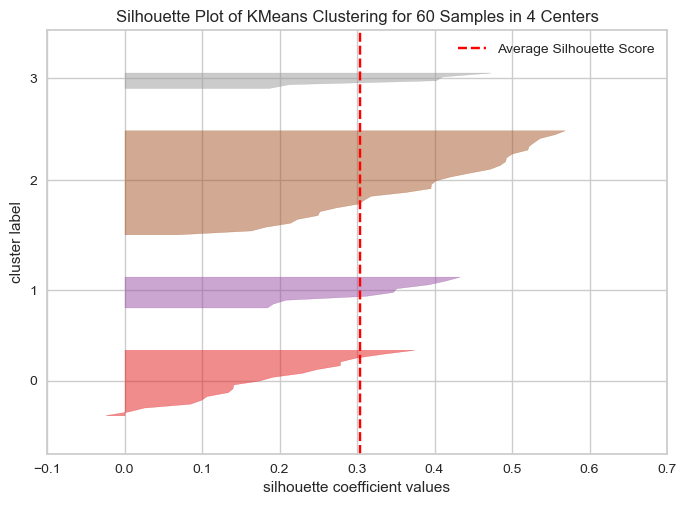

In [13]:
model_KMeans_4 = KMeans(random_state=42, n_clusters=4)
silhouette_4 = SilhouetteVisualizer(model_KMeans_4)

silhouette_4.fit(X_scaled)        # Fit the data to the visualizer
silhouette_4.show();        # Finalize and render the figure

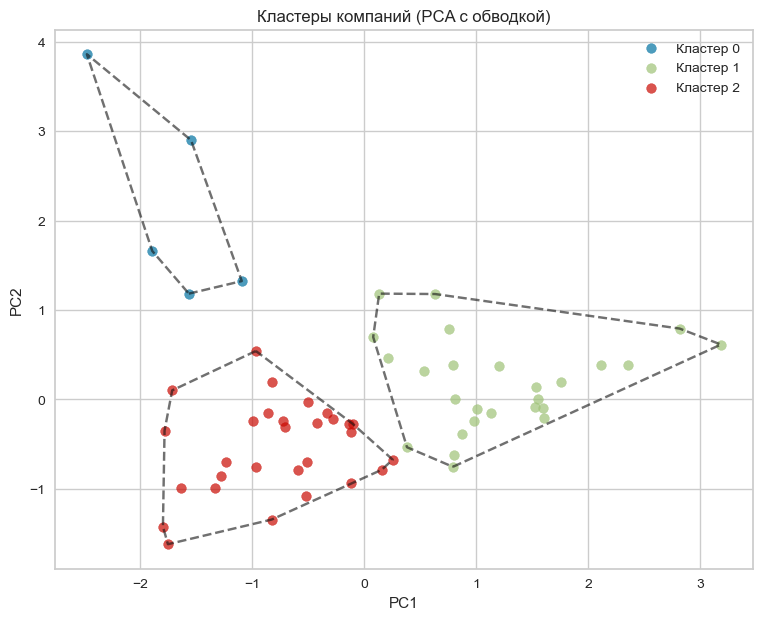

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np

# === PCA до 2 компонент ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Добавим координаты PCA в rfm
rfm['pca1'] = X_pca[:,0]
rfm['pca2'] = X_pca[:,1]

# === Визуализация с обводкой кластеров ===
plt.figure(figsize=(9,7))

for cluster in rfm['cluster'].unique():
    subset = rfm[rfm['cluster'] == cluster]
    plt.scatter(subset['pca1'], subset['pca2'], label=f"Кластер {cluster}", alpha=0.7)

    # Рисуем выпуклую оболочку (обводку) для кластера
    if len(subset) >= 3:  # ConvexHull требует минимум 3 точки
        points = subset[['pca1','pca2']].values
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # замкнуть контур
        plt.plot(points[hull_points,0], points[hull_points,1], 'k--', alpha=0.6)

plt.title("Кластеры компаний (PCA с обводкой)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


## Иерархическая кластеризация

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

In [17]:
# === Иерархическая кластеризация ===
Z = linkage(X_scaled, method='ward')  # Ward = минимизация дисперсий

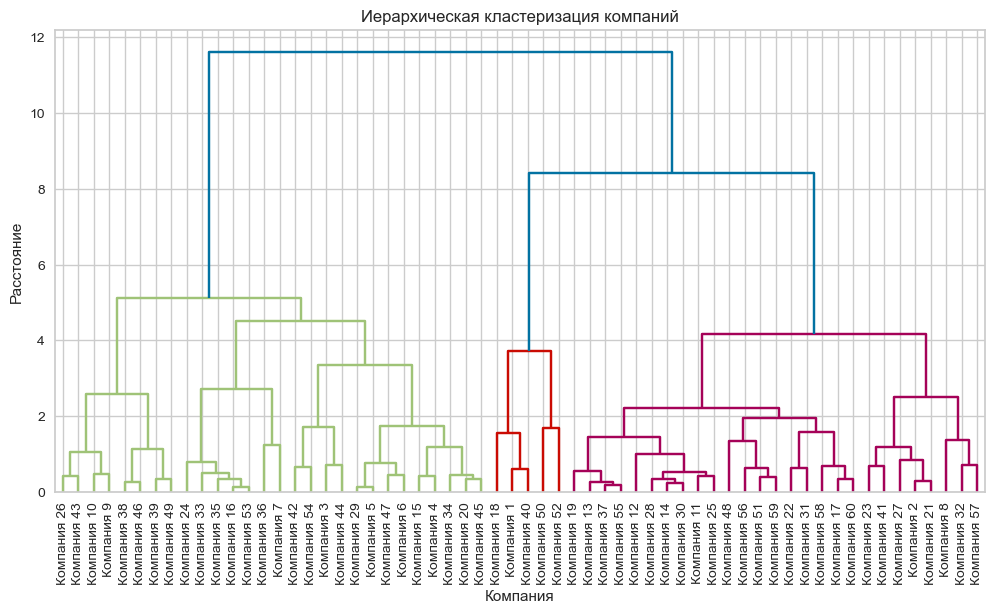

In [18]:
# Рисуем дендрограмму
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=rfm['компания'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Иерархическая кластеризация компаний")
plt.xlabel("Компания")
plt.ylabel("Расстояние")
plt.show()


In [19]:
# === Получаем метки кластеров (например, 3 кластера) ===
rfm['hier_cluster'] = fcluster(Z, t=3, criterion='maxclust')

print("Примеры компаний с иерархическими кластерами:")
print(rfm[['компания','recency','frequency','monetary','hier_cluster']].head())

Примеры компаний с иерархическими кластерами:
      компания  recency  frequency   monetary  hier_cluster
0   Компания 1      148        347  308281.80             2
1  Компания 10       34        340  401197.34             1
2  Компания 11       56        345  333882.67             3
3  Компания 12       96        343  329115.47             3
4  Компания 13       30        348  338580.73             3


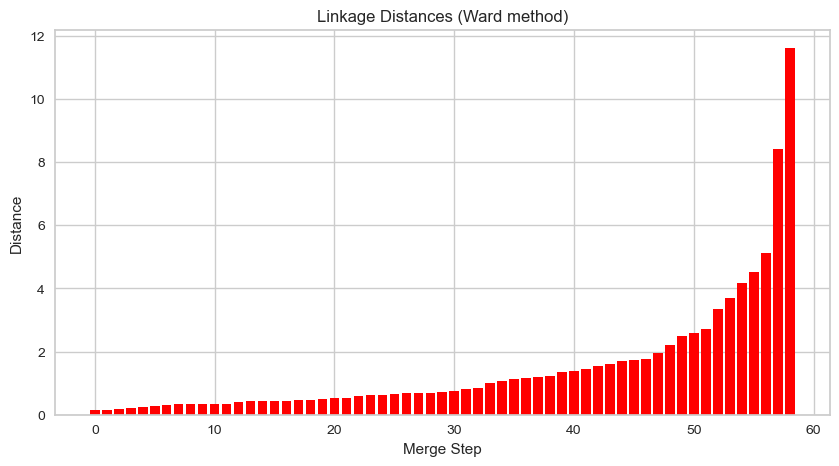

In [20]:
# === Визуализация расстояний объединения кластеров ===
used_distances = Z[:, 2]  # расстояния из linkage

plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(used_distances)), used_distances, color="red")
plt.xlabel("Merge Step")
plt.ylabel("Distance")
plt.title("Linkage Distances (Ward method)")
plt.show()


Оптимальное количество кластеров - 4

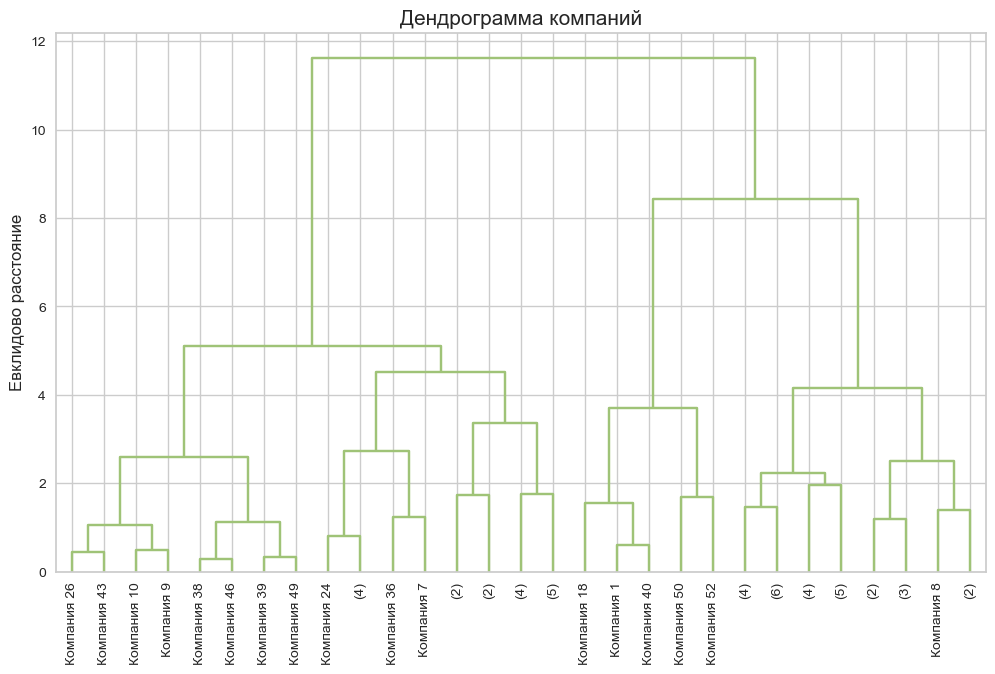

In [23]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram

# === Дендрограмма ===
plt.figure(figsize=(12, 7))
dendrogram = shc.dendrogram(
    Z,
    labels=rfm['компания'].values,  # показываем названия компаний вместо индексов
    leaf_rotation=90,               # поворот подписей
    leaf_font_size=10,              # размер шрифта для компаний
    color_threshold=40,             # горизонтальная линия на высоте 40
    truncate_mode='level',          # сокращение уровней для читаемости
    p=4                             # показываем только последние 4 уровня
)

plt.title("Дендрограмма компаний", fontsize=15)
plt.ylabel("Евклидово расстояние", fontsize=12)
plt.show()


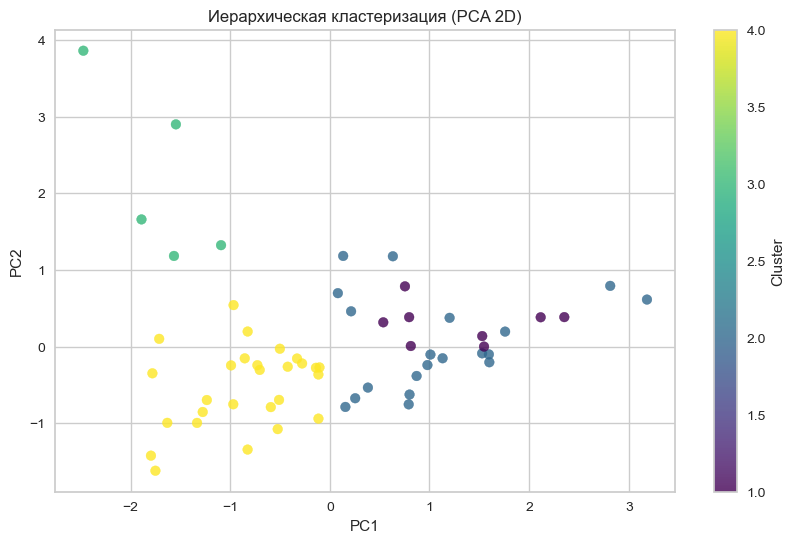

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === PCA до 2 компонент ===
pca = PCA(n_components=2)
X_3d_to_2d = pca.fit_transform(X_scaled)

# Кластеризация (например, на 3 кластера)
from scipy.cluster.hierarchy import fcluster
df_shc_labels = fcluster(Z, t=4, criterion='maxclust')

# === Scatter plot кластеров ===
plt.figure(figsize=(10, 6))
plt.scatter(X_3d_to_2d[:, 0], X_3d_to_2d[:, 1], c=df_shc_labels, cmap='viridis', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Иерархическая кластеризация (PCA 2D)")
plt.colorbar(label="Cluster")
plt.show()


In [27]:
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

# === Получаем метки кластеров (например, 4 кластера по дистанции) ===
clusters = shc.fcluster(Z, 4, criterion='distance')

# === Оценка качества кластеризации (силуэт) ===
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score (Hierarchical, 4 clusters): {silhouette_avg:.3f}")


Silhouette Score (Hierarchical, 4 clusters): 0.284


In [28]:
model_KMeans_2 = KMeans(random_state=42, n_clusters=2)
rfm['cluster'] = model_KMeans_3.fit_predict(X_scaled)

c:\anaconda\envs\lab_01\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


c:\anaconda\envs\lab_01\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score (2 кластера): 0.337


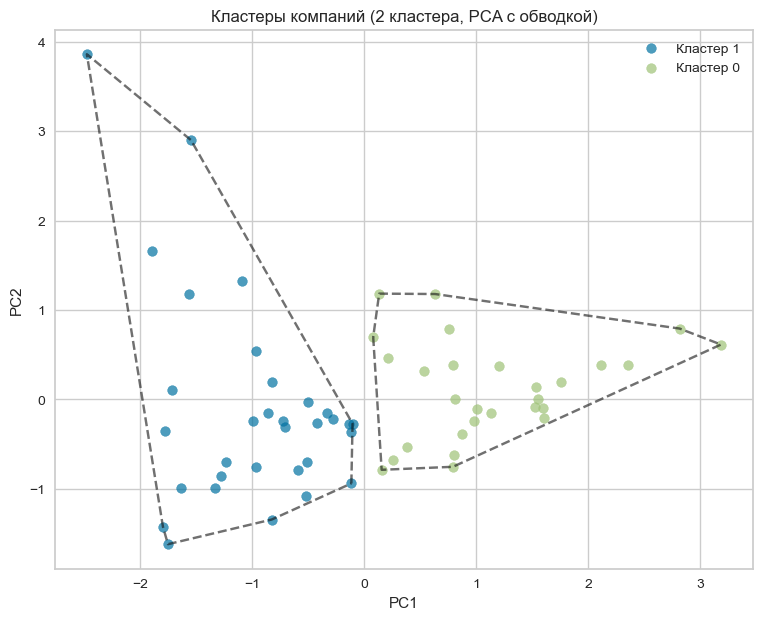

In [31]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np

# === KMeans с 2 кластерами ===
kmeans_2 = KMeans(n_clusters=2, random_state=42)
rfm['cluster_2'] = kmeans_2.fit_predict(X_scaled)

# === Силуэтный коэффициент ===
silhouette_avg = silhouette_score(X_scaled, rfm['cluster_2'])
print(f"Silhouette Score (2 кластера): {silhouette_avg:.3f}")

# === PCA до 2 компонент ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

rfm['pca1'] = X_pca[:,0]
rfm['pca2'] = X_pca[:,1]

# === Визуализация с обводкой кластеров ===
plt.figure(figsize=(9,7))

for cluster in rfm['cluster_2'].unique():
    subset = rfm[rfm['cluster_2'] == cluster]
    plt.scatter(subset['pca1'], subset['pca2'], label=f"Кластер {cluster}", alpha=0.7)

    # Рисуем выпуклую оболочку (обводку) для кластера
    if len(subset) >= 3:  # ConvexHull требует минимум 3 точки
        points = subset[['pca1','pca2']].values
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # замыкаем контур
        plt.plot(points[hull_points,0], points[hull_points,1], 'k--', alpha=0.6)

plt.title("Кластеры компаний (2 кластера, PCA с обводкой)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# === 5. Интерпретация кластеров ===
cluster_summary = rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'компания': 'count'
}).rename(columns={'компания': 'num_companies'})

def label_cluster(row, summary):
    c = row['cluster']
    r, f, m = row['recency'], row['frequency'], row['monetary']
    r_mean, f_mean, m_mean = summary['recency'].mean(), summary['frequency'].mean(), summary['monetary'].mean()
    
    if r < r_mean and f > f_mean and m > m_mean:
        return "Лояльные"
    elif r > r_mean and f < f_mean:
        return "Рисковые"
    else:
        return "Сомневающиеся"

rfm['cluster_label'] = rfm.apply(lambda row: label_cluster(row, cluster_summary), axis=1)

# === 6. Результаты ===
print("Сегменты клиентов:")
print(cluster_summary)

print("\nПолный список компаний с сегментами:")
print(rfm[['компания','recency','frequency','monetary','cluster','cluster_label']])

# === 7. Сохранение ===
rfm.to_excel("rfm_clusters_3.xlsx", index=False)

summary_report = rfm.groupby('cluster_label').agg({
    'recency': ['mean','min','max'],
    'frequency': ['mean','min','max'],
    'monetary': ['mean','min','max'],
    'компания': 'count'
}).rename(columns={'компания': 'num_companies'})

summary_report.to_excel("rfm_summary_report_3.xlsx")

print("\nСводный отчёт по сегментам сохранён в rfm_summary_report_3.xlsx")


Сегменты клиентов:
            recency   frequency       monetary  num_companies
cluster                                                      
0        198.000000  345.800000  327427.336000              5
1         26.076923  367.923077  376264.878077             26
2         38.551724  340.689655  316601.266207             29

Полный список компаний с сегментами:
       компания  recency  frequency   monetary  cluster  cluster_label
0    Компания 1      148        347  308281.80        0       Рисковые
1   Компания 10       34        340  401197.34        1  Сомневающиеся
2   Компания 11       56        345  333882.67        2  Сомневающиеся
3   Компания 12       96        343  329115.47        2       Рисковые
4   Компания 13       30        348  338580.73        2  Сомневающиеся
5   Компания 14       59        341  321698.99        2  Сомневающиеся
6   Компания 15        1        374  322919.46        1  Сомневающиеся
7   Компания 16       13        382  358734.80        1       Лоя